Source: https://pm4py.fit.fraunhofer.de/documentation

# Step 0: Imports and defining functions

Imports

In [44]:
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.filtering.log.timestamp import timestamp_filter
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.statistics.traces.log import case_statistics
import statsmodels.api as sm 
from graphviz import Source
import networkx as nx
import matplotlib.pyplot as plt
import ruptures as rpt
import pandas as pd
import json
import pm4py
import math
import numpy as np
import re
import datetime

Custom functions:

In [27]:
#Function to convert the DOT output source code to a dataframe of the graph
def dot_to_df(gviz):

    node_name = []
    node_l = []
    node_occ = []

    edge_from = []
    edge_to = []
    edge_label = []

    for x in gviz.source.split('\n'):
        #print(x)
        node = re.search('\t([-]{0,1}[0-9]+) \[label',x)
        if node is not None:
            node = node.groups()[0]

        node_label = re.search('\[label="([a-zA-Z0-9 ]*)',x)
        if node_label is not None:
            node_label = node_label.groups()[0]

        node_occurrence = re.search('\[label="[a-zA-Z0-9 ]*\(([0-9]*)\)',x)
        if node_occurrence is not None:
            node_occurrence = node_occurrence.groups()[0]

        edge_f = re.search('\t([-]{0,1}[0-9]+) ->',x)
        if edge_f is not None:
            edge_f = edge_f.groups()[0]

        edge_t = re.search('-> ([-]{0,1}[0-9]+) \[label',x)
        if edge_t is not None:
            edge_t =edge_t.groups()[0]

        edge_l = re.search('-> [-]{0,1}[0-9]+ \[label=([0-9]+)',x)
        if edge_l is not None:
            edge_l = edge_l.groups()[0]

        # Append the edge or node to the appropriate lists
        if (node is not None) and (node_label is not None) and (node_occurrence is not None):
            node_name.append(node)
            node_l.append(node_label)
            node_occ.append(node_occurrence)

        if (edge_f is not None) and (edge_t is not None) and (edge_l is not None):
            edge_from.append(edge_f)
            edge_to.append(edge_t)
            edge_label.append(edge_l)

    # Create the dataframe from the lists

    d = {"node": node_name, "node_label": node_l, "node_occurrence": node_occ}
    nodes = pd.DataFrame(data=d)

    d = {"edge_from": edge_from, "edge_to": edge_to, "edge_label": edge_label}
    edges = pd.DataFrame(data=d)
    
    return nodes, edges

# Step 1: Examine the the log file and identify change points

First we simply check which variables are available in the log. There must be a 'time:timestamp' attribut in order for the code to work.

In [28]:
log = xes_importer.apply('italian_help_desk.xes')
attributes_list = pm4py.get_attributes(log)
print(attributes_list)
variants = pm4py.get_variants(log)


['Resource', 'concept:name', 'time:timestamp', 'org:resource', 'Activity']


As a next step, we plot the events on the time dimension, and we identify change points in the dataset.

*The current implementation only considers the number of events on a given day, however the used library allows for more complex change point identification with considering multi-dimensional datasources. Other dimensions could be: ratio of variants, active traces, etc... Also, different statistical models can be used for change-point identification. More info in the documentation of the 'ruptures' library: https://github.com/deepcharles/ruptures*

Available models (cost functions): rbf (default), ar, clinear, cosine, l1, l2, linear, mahalanobis, normal, rank

There is an option to set the Sensitivity of the model, which determines the number of change-points in the time series. The lower the sensitivity is, the fewer breakpoints will be recognised.

Start date:  2010-01-13 
End date:  2014-01-03


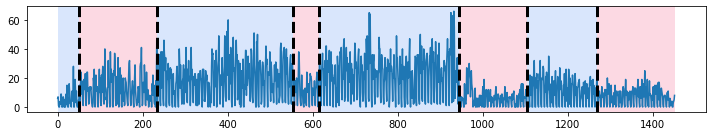

In [29]:
#USER SELECTION ------
PENALTY = 4
MODEL = "rbf"
#---------------------

attr_datetime = pm4py.get_attribute_values(log, 'time:timestamp')
start_date = min(attr_datetime).date()
end_date = max(attr_datetime).date()
delta = datetime.timedelta(days=1)
print("Start date: ", start_date, "\nEnd date: ", end_date)

event_counts = {}
i = start_date
while i <= end_date:
    event_counts[i.strftime('%Y-%m-%d')] = 0
    #print(i)
    i += delta

#print(event_counts)

for t in attr_datetime:
    event_counts[t.date().strftime('%Y-%m-%d')] += 1

dates = np.array(list(event_counts.values()))

# detection
algo = rpt.Pelt(model=MODEL).fit(dates)
detect_result = algo.predict(pen=PENALTY)

# display
rpt.display(dates, detect_result, detect_result)
#print(rpt.display(dates, detect_result, detect_result)[1][0].show())
#plt.xticks(range(1,len(dates)),list(event_counts.keys()))
plt.show()
#fig, ax = plt.subplots() # or 
#fig.savefig('change-points.eps', format='eps')
#print(plt.axis())
#print(list(event_counts.keys()))

# Step 2: Directly-Follows Graph for the full dataset

This code simply constructs the full DFG for the log, without any filters.

*Since the base graph will be always the full graph (to avoid issues with having different layouts or missing nodes and edges between versions), here could be an option to remove some edges and/or nodes completely, so they do not show up anymore in any graphs. With this option, the unnecessary objects can be removed (e.g. edges that only occur once or twice and have no significance).*

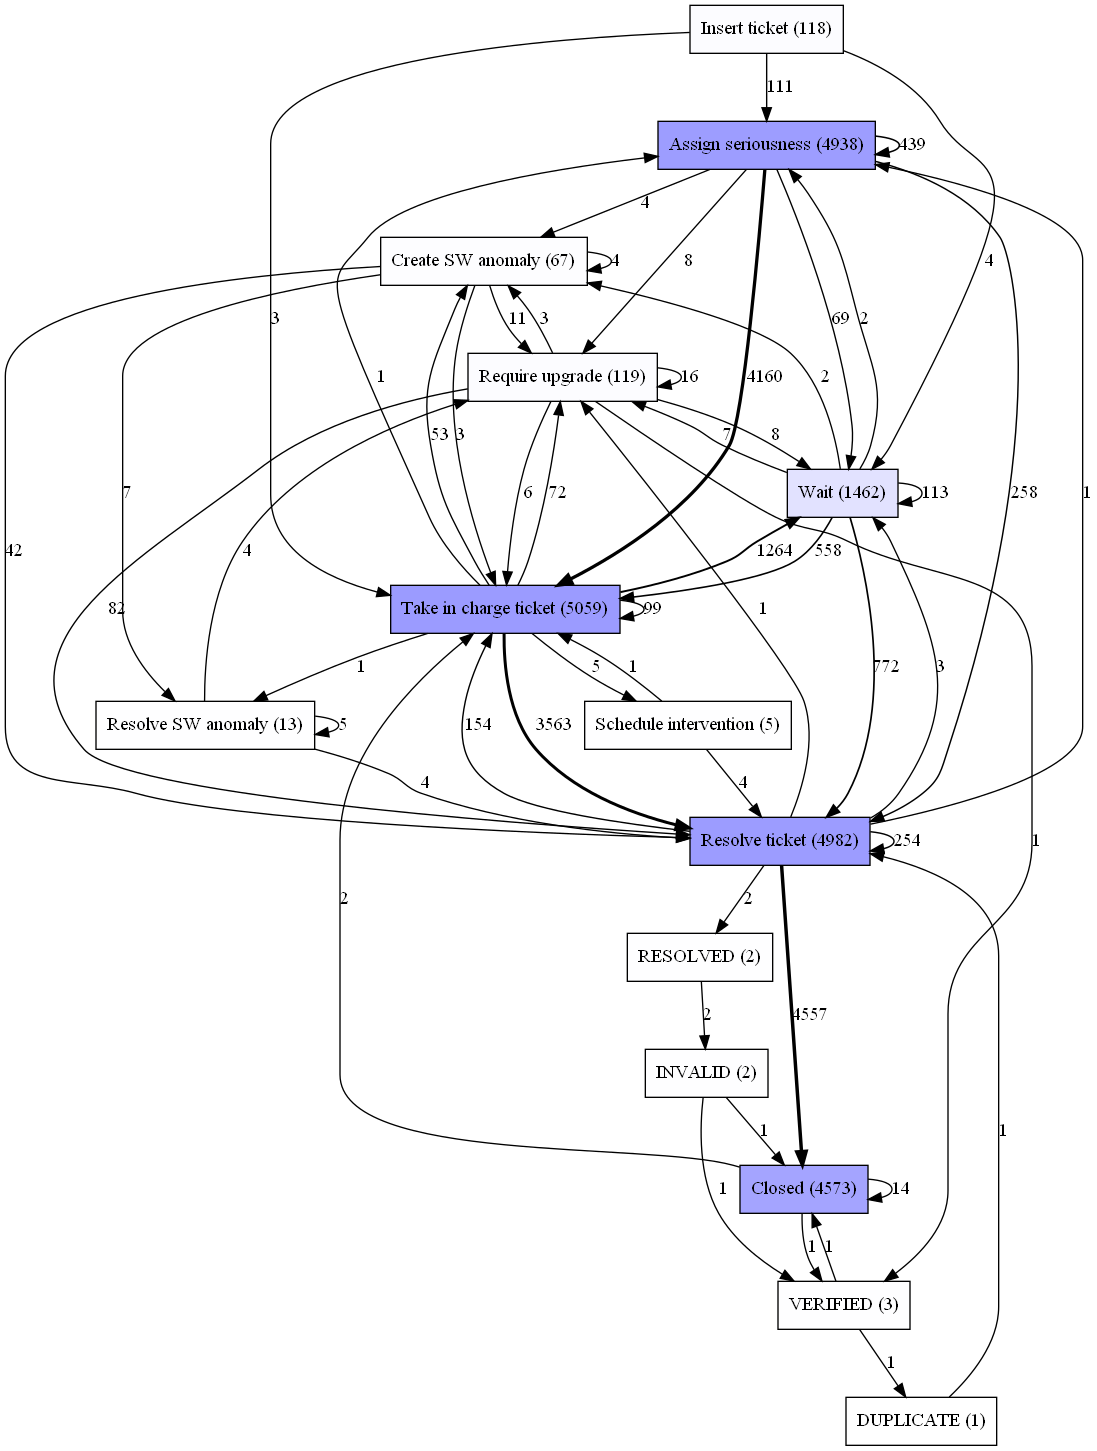

In [30]:
dfg = dfg_discovery.apply(log)

gviz = dfg_visualization.apply(dfg, log=log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)

Creating the dataframes (nodes and edges) for the full graph:

In [31]:
nodes_full, edges_full = dot_to_df(gviz)
#nodes_full

#Here nodes and edges can be removed from the full graph - if needed

# Step 3: Filter for two timeframes to compare

As a reminder, we show the defined time periods again for selection

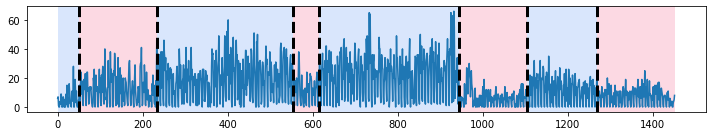

In [32]:
rpt.display(dates, detect_result, detect_result)
plt.show()

Here the user selects one (or two) periods identified in Step 1. The time slices between breakpoints are numbered from 1 until the last period (from left to right). So the user has the option to filter any of the periods by giving its order number in the code below.

Two filtering options are available: filtering for traces that are fully contained in the timeframe, or traces that intersect with the timeframe. We are using the filter_traces_contained method for our implementation.

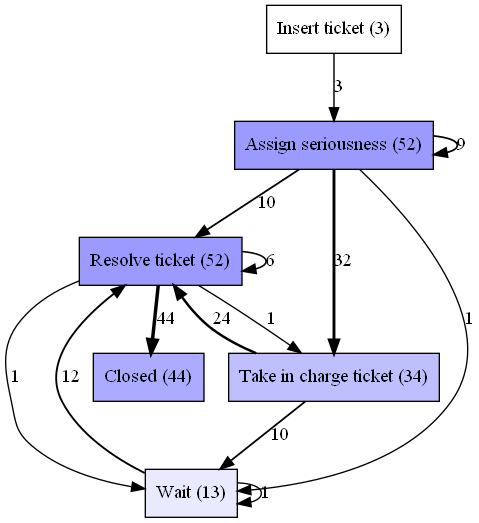

In [45]:
# USER SELECTION -------
CHOSEN_PERIOD1 = 4
CHOSEN_PERIOD2 = 6
# ----------------------

start_element1 = 0 if CHOSEN_PERIOD1 == 1 else detect_result[CHOSEN_PERIOD1-2]
end_element1 = detect_result[CHOSEN_PERIOD1-1]

start_element2 = 0 if CHOSEN_PERIOD2 == 1 else detect_result[CHOSEN_PERIOD2-2]
end_element2 = detect_result[CHOSEN_PERIOD2-1]

days = list(event_counts.keys())
#print(days[start_element1])
start_day1 = days[start_element1]
end_day1 = days[end_element1-1]
days_count1 = end_element1 - start_element1

start_day2 = days[start_element2]
end_day2 = days[end_element2-1]
days_count2 = end_element2 - start_element2

# Traces that are FULLY CONTAINED in the given timeframe
period_1_log = timestamp_filter.filter_traces_contained(log, start_day1+" 00:00:00", end_day1+" 23:59:59")
period_2_log = timestamp_filter.filter_traces_contained(log, start_day2+" 00:00:00", end_day2+" 23:59:59")

# Traces that INTERSECT with the given timeframe
# period_1_log = timestamp_filter.filter_traces_intersecting(log, start_day+" 00:00:00", end_day+" 23:59:59")

dfg1 = dfg_discovery.apply(period_1_log)
dfg2 = dfg_discovery.apply(period_2_log)

gviz = dfg_visualization.apply(dfg1, log=period_1_log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)

# Saving the DFG
#parameters = {dfg_visualization.Variants.PERFORMANCE.value.Parameters.FORMAT: "svg"}
#gviz = dfg_visualization.apply(dfg1, log=period_1_log, variant=dfg_visualization.Variants.FREQUENCY, parameters=parameters)
#dfg_visualization.save(gviz, "dfg1.svg")

nodes_period1, edges_period1 = dot_to_df(gviz)
#nodes_period1

Showing the DFG for the second period:

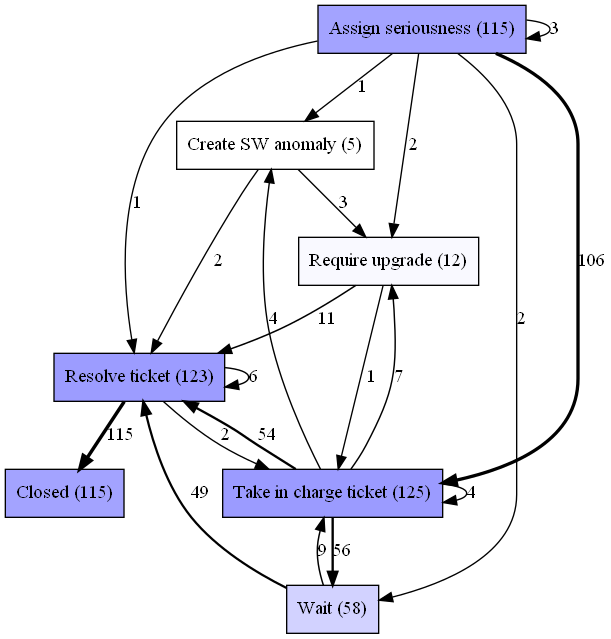

In [46]:
gviz = dfg_visualization.apply(dfg2, log=period_2_log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)

# Saving the DFG
#parameters = {dfg_visualization.Variants.PERFORMANCE.value.Parameters.FORMAT: "svg"}
#gviz = dfg_visualization.apply(dfg2, log=period_2_log, variant=dfg_visualization.Variants.FREQUENCY, parameters=parameters)
#dfg_visualization.save(gviz, "dfg2.svg")

nodes_period2, edges_period2 = dot_to_df(gviz)
#nodes_period2

Calculate the number of traces in each timeframe. This is required to show the statistical information regarding the drift proportional to the covered timeframe.

In [47]:
variants_count1 = case_statistics.get_variant_statistics(period_1_log)
variants_count1 = sorted(variants_count1, key=lambda x: x['count'], reverse=True)

variants_count2 = case_statistics.get_variant_statistics(period_2_log)
variants_count2 = sorted(variants_count2, key=lambda x: x['count'], reverse=True)

trace_count1 = 0
trace_count2 = 0

for i in variants_count1:
    trace_count1 += i["count"]

for i in variants_count2:
    trace_count2 += i["count"]

# Variables so far to help calculate the drifts 
#trace_count1
#trace_count2
#print(days_count1)
#print(start_day1)
#print(end_day1)
#print(days_count2)
#print(start_day2)
#print(end_day2)
#nodes_period1
#nodes_period2
#edges_period1
#edges_period2

# Step 4: Calculate slope for each edge on the DFG

We want to add to each of the edges dataframes the slope of a given edge. In order to do that, we break the task down into functions.

1. We iterate through each of the edge in each of the dataframes to calculate the slope.
2. For each edge (or transition), we build a time series, which tells us on which day how many times that transition happened
3. Then we can calculate a linear regression trendline on this time series to see, whether this specific transition is occurring more often over time, or less.

Because we considered each time period as a homogenous block, we can disregard all the other irregularities, and take only the trendline and its slope as a measure of change.

User task: The ACTIVITY_NAMES contains the name of the variable in the log file, which stores the activity's name (displayed on the DFG). This might differ in each case, so there is an option to modify it at the beginning of the next block.

In [36]:
# USER SELECTION
#--------------------------------
ACTIVITY_NAMES = 'concept:name'
#--------------------------------

def slope_from_dateseries(time_series):
    # Calculating the trendline for the given time series
    # with linear regression
    day_order = []
    for i in range(0, len(time_series.index)):
        day_order.append(i)
    x = day_order
    y = time_series['count'].tolist() 
    #plt.scatter(x, y) 

    # adding the constant term 
    x = sm.add_constant(x) 

    result = sm.OLS(y, x).fit() 
    return result.params[1]

def get_slope(start_node, end_node, log):
    # Here we filter for a transition withing a given (filtered) log file
    # and we call the slope_from_dateseries on it in order to get the slope
    dataframe = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)
    unique_cases = dataframe['case:concept:name'].unique()
    nunique_cases = dataframe['case:concept:name'].nunique()
    time_series = []
    
    for n in range(nunique_cases):
        case_df = dataframe[dataframe['case:concept:name'] == unique_cases[n]]
        case_df.sort_values(by=['time:timestamp'])
        for index, row in case_df.iterrows():
            #print(row)
            if min(case_df.index) + len(case_df.index) - 1 == index:
                break
            elif row[ACTIVITY_NAMES] == start_node and case_df.loc[index+1, ACTIVITY_NAMES] == end_node:
                time_series.append(case_df.loc[index+1, 'time:timestamp'])
        del case_df
    
    day_min = min(time_series).date()
    day_max = max(time_series).date()
    
    df = pd.DataFrame()
    
    date_series = []
    for x in time_series:
        date_series.append(x.date())
    
    daterange = pd.date_range(start=day_min, end=day_max)
    
    for single_date in daterange:
        #print(single_date)
        data = [{'day': single_date.strftime("%Y-%m-%d"), 'count': date_series.count(single_date.date())}]
        df = df.append(data, ignore_index=True)
    
    slope = slope_from_dateseries(df)
    
    return slope

def add_slope_to_period_df(edges, log):
    # We loop through each of the edges in our dataframe,
    # and call the get_slope function 
    edges["slope"] = 0
    print("Calculating slope for each transition....")
    for index, row in edges.iterrows():
        try:
            from_node = nodes_full.loc[nodes_full["node"] == row["edge_from"],"node_label"].iloc[0].strip()
            to_node = nodes_full.loc[nodes_full["node"] == row["edge_to"],"node_label"].iloc[0].strip()
            print("Transition: ", from_node," -> ", to_node)
            edges.loc[index, "slope"] = get_slope(from_node, to_node, log)
        except:
            pass
    print("Done.")
    return edges

add_slope_to_period_df(edges_period1, period_1_log)
add_slope_to_period_df(edges_period2, period_2_log)
print('Slopes are added to the period dataframes')
#slope = get_slope('Resolve ticket', 'Closed', period_1_log)
#slope

Calculating slope for each transition....
Transition:  Assign seriousness  ->  Assign seriousness
Transition:  Assign seriousness  ->  Resolve ticket
Transition:  Assign seriousness  ->  Take in charge ticket
Transition:  Assign seriousness  ->  Wait
Transition:  Insert ticket  ->  Assign seriousness
Transition:  Resolve ticket  ->  Closed
Transition:  Resolve ticket  ->  Resolve ticket
Transition:  Resolve ticket  ->  Take in charge ticket
Transition:  Resolve ticket  ->  Wait
Transition:  Take in charge ticket  ->  Resolve ticket
Transition:  Take in charge ticket  ->  Wait
Transition:  Wait  ->  Resolve ticket
Transition:  Wait  ->  Wait
Done.
Calculating slope for each transition....
Transition:  Assign seriousness  ->  Assign seriousness
Transition:  Assign seriousness  ->  Create SW anomaly
Transition:  Assign seriousness  ->  Require upgrade
Transition:  Assign seriousness  ->  Resolve ticket
Transition:  Assign seriousness  ->  Take in charge ticket
Transition:  Assign seriousn

Here we merge the two dataframes containing the transitions of the two time periods into an edges_merged dataframe.

In [37]:
edges_period1["daily_avg"] = edges_period1["edge_label"].astype(int) / days_count1
edges_period2["daily_avg"] = edges_period2["edge_label"].astype(int) / days_count2
edges_merged = edges_full.copy()
edges_merged["edge_label"] = 0
edges_merged["daily_avg"] = 0
edges_merged["daily_diff"] = 0
edges_merged["slope"] = 0
edges_merged["slope_diff"] = 0

for index, row in edges_merged.iterrows():
    for i, r in edges_period2.iterrows():
        if r["edge_from"] == row["edge_from"] and r["edge_to"] == row["edge_to"]:
            edges_merged.loc[index, "edge_label"] = r["edge_label"]
            edges_merged.loc[index, "daily_avg"] = r["daily_avg"]
            edges_merged.loc[index, "slope"] = r["slope"]
            
    for i, r in edges_period1.iterrows():
        if (r["edge_from"] == row["edge_from"] and r["edge_to"] == row["edge_to"]) and r["daily_avg"] != 0:
            edges_merged.loc[index, "daily_diff"] = edges_merged.loc[index, "daily_avg"] / r["daily_avg"] - 1
        
        if (r["edge_from"] == row["edge_from"] and r["edge_to"] == row["edge_to"]) and r["slope"] != 0:
            edges_merged.loc[index, "slope_diff"] = edges_merged.loc[index, "slope"] - r["slope"]

# Removing edges which do not exist in the first period and in the second either
edges_merged = edges_merged[(edges_merged[['daily_avg','daily_diff', 'slope', 'slope_diff']] != 0).any(axis=1)]

edges_merged
#nodes_full

,edge_from,edge_to,edge_label,daily_avg,daily_diff,slope,slope_diff
0,6547090912748384973,6547090912748384973,3,0.01875,-0.875000,-9.380863e-05,-0.119211
1,6547090912748384973,-1169008742493800415,1,0.00625,0.000000,0.000000e+00,0.000000
2,6547090912748384973,7298165384196776250,2,0.01250,0.000000,6.938894e-18,0.000000
3,6547090912748384973,6858718998437972403,1,0.00625,-0.962500,0.000000e+00,0.017778
4,6547090912748384973,5152796590213100755,106,0.66250,0.242188,-7.650842e-03,0.043996
5,6547090912748384973,-8211352665689454929,2,0.01250,-0.250000,5.637851e-18,0.000000
10,-1169008742493800415,7298165384196776250,3,0.01875,0.000000,-2.511952e-03,0.000000
12,-1169008742493800415,6858718998437972403,2,0.01250,0.000000,-3.469447e-18,0.000000
17,7265369421959381715,6547090912748384973,0,0.00000,-1.000000,0.000000e+00,0.000000
23,7298165384196776250,6858718998437972403,11,0.06875,0.000000,1.367989e-04,0.000000


# Step 5: Visualize the DFG

As a last step, we take the nodes and edges dataframes, and compile the DOT source code for the graphviz object, so that it includes the color of the edge, as well as the 


digraph {
	graph [bgcolor=transparent]
	node [shape=box]
	6547090912748384973 [label="Assign seriousness " fillcolor="#FFFFFF" style=filled]
	699187169604955628 [label="Closed " fillcolor="#FFFFFF" style=filled]
	-1169008742493800415 [label="Create SW anomaly " fillcolor="#FFFFFF" style=filled]
	4998266672074382329 [label="DUPLICATE " fillcolor="#FFFFFF" style=filled]
	1196759794980265741 [label="INVALID " fillcolor="#FFFFFF" style=filled]
	7265369421959381715 [label="Insert ticket " fillcolor="#FFFFFF" style=filled]
	-6420277243801546163 [label="RESOLVED " fillcolor="#FFFFFF" style=filled]
	7298165384196776250 [label="Require upgrade " fillcolor="#FFFFFF" style=filled]
	-3755261841395197578 [label="Resolve SW anomaly " fillcolor="#FFFFFF" style=filled]
	6858718998437972403 [label="Resolve ticket " fillcolor="#FFFFFF" style=filled]
	819064737868417575 [label="Schedule intervention " fillcolor="#FFFFFF" style=filled]
	5152796590213100755 [label="Take in charge ticket " fillcolor="#FFFF

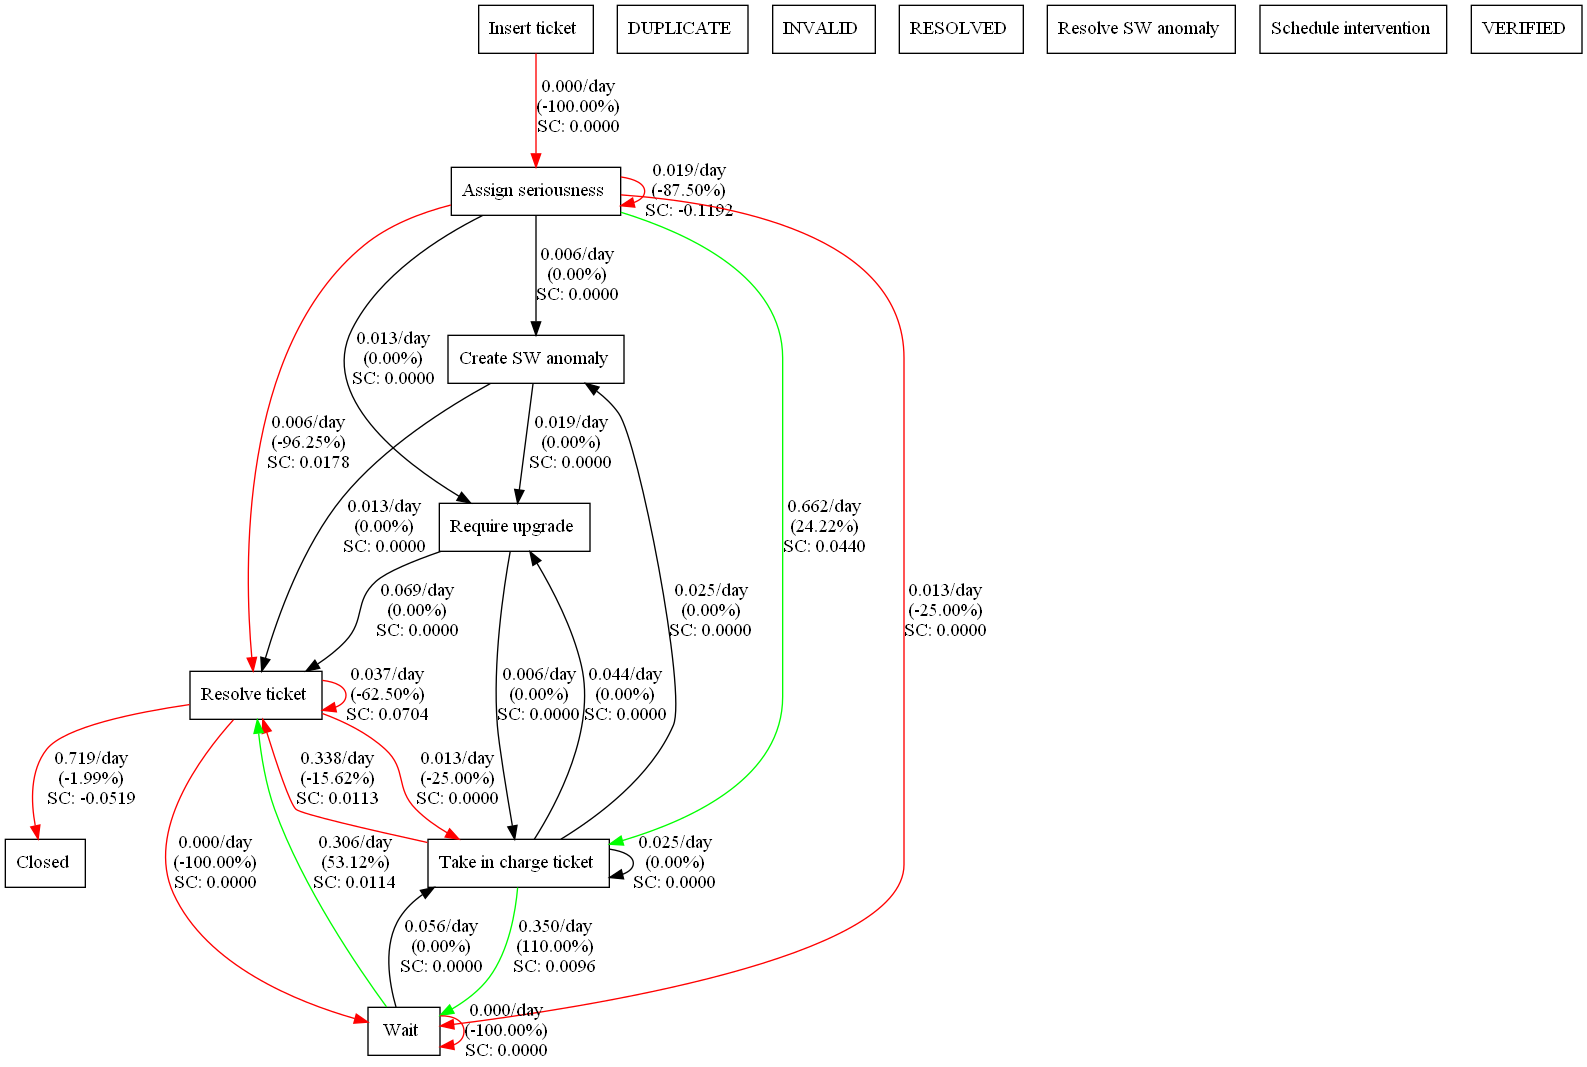

In [43]:
#print(gviz.source)

def df_to_dot(nodes, edges):
    s = """
digraph {
	graph [bgcolor=transparent]
	node [shape=box]
"""
    for index, row in nodes.iterrows():
        s += '	' + row["node"] +' [label="' + row["node_label"] + '" fillcolor="#FFFFFF" style=filled]\n'
    
    for index, row in edges.iterrows():
        s += '	' + row["edge_from"] +' -> ' + row["edge_to"] + ' [label="' \
                + str("{:.3f}".format(row["daily_avg"])) + '/day\\n(' + str("{:.2f}".format(row["daily_diff"]*100)) \
                + '%)\\nSC: ' + str("{:.4f}".format(row["slope_diff"])) + '" penwidth=1.0 color="'
        if row["daily_diff"] < 0:
            s+= 'red'
        elif row["daily_diff"] > 0:
            s+= 'green'
        else:
            s+= 'black'
        s += '"]\n'
    s += """
	overlap=false
	fontsize=10
}
"""
    gviz = Source(s, filename="merged_dfg.gv", format="png")
    return gviz

gviz_merge = df_to_dot(nodes_full, edges_merged)
print(gviz_merge)
dfg_visualization.view(gviz_merge)
